<h1> Anomaly detection </h1>

- examples of anomaly detection use cases:
    - fraud detection - insurance fraud, credit card fraud, money laundering, product warranty, tax evasion, healthcare fraud, ...
    - predictive/preventive maintenance
    - network intrusion
    - misuse of services

<img src="images/rules.png" width=500>
image source: AWS

- advantages of machine learning approach over pure rule-based approach:
    - models adapt to data - uses all data vs. just one threshold value per feature
    - can change over time
    - can capture feature interactions
    - can give score
    - better performance

---

<h3>Imbalanced data</h3>

- in supervised learning mode
- anomaly is uncommon (by definition)
- we can use resampling of the training data
- never resample test data

In [3]:
# import useful libraries

# data wrangling
import pandas as pd
import numpy as np

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
from plotly.graph_objects import Scatter, Layout

# statistics
from scipy import stats

# machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

# for imbalanced datasets, compatible with scikit-learn
from imblearn.over_sampling import RandomOverSampler, SMOTE

The data are not present in the code repository. <a href="https://drive.google.com/file/d/1XX7955J2OY34VwymafiPsuF4ZcEDcuOT/view?usp=sharing">Here you can download the credit-card dataset.</a> After download, put it in the WEEK_3/data.

In [2]:
# load credit card dataset
df = pd.read_csv("data/creditcard.csv")

In [3]:
# inspect the dataset
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [4]:
# inspect the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# labels and respective counts
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

- there are 284315 normal cases, and only 492 case of fraud, this is very much imbalanced dataset

**Common resampling methods**

<img src="images/undersampling.png" width=300>
image source: <a href=https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets>https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets</a>

<img src="images/oversampling.png" width=300>
image source: <a href=https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets>https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets</a>

<img src="images/smote.png" width=500>
image source: <a href=https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets>https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets</a>

- random undersampling: throw away data
    - computationally efficient
    - information loss
- random oversampling: straightforward and simple, but training your model on many duplicates
    - watch over for overfitting
- Synthetic Minority Oversampling Technique (SMOTE): more sophisticated and realistic dataset, but you are training on "fake" data

In [6]:
# create RandomOverSampler object
ros = RandomOverSampler(random_state=42)

# randomly oversample the original dataset
X_res, y_res = ros.fit_resample(df.loc[:, df.columns!='Class'], df["Class"])

In [7]:
# check value counts of both classes
y_res.value_counts()

1    284315
0    284315
Name: Class, dtype: int64

In [8]:
# combine features and labels to single dataframe
df_res = pd.concat([X_res, y_res], axis=1)

In [9]:
# set float display format
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [10]:
# comparing original...
df[df["Class"]==1]["V1"].describe()

count   492.00000
mean     -4.77195
std       6.78369
min     -30.55238
25%      -6.03606
50%      -2.34250
75%      -0.41920
max       2.13239
Name: V1, dtype: float64

In [11]:
# with resampled dataset 
df_res[df_res["Class"]==1]["V1"].describe()

count   284315.00000
mean        -4.77738
std          6.79681
min        -30.55238
25%         -6.00342
50%         -2.33565
75%         -0.41734
max          2.13239
Name: V1, dtype: float64

In [12]:
# create SMOTE object
ros = SMOTE(random_state=42)

# randomly oversample the original dataset
X_res, y_res = ros.fit_resample(df.loc[:, df.columns!='Class'], df["Class"])

In [13]:
# combine features and labels to single dataframe
df_res = pd.concat([X_res, y_res], axis=1)

In [14]:
# comparing original...
df[df["Class"]==1]["V1"].describe()

count   492.00000
mean     -4.77195
std       6.78369
min     -30.55238
25%      -6.03606
50%      -2.34250
75%      -0.41920
max       2.13239
Name: V1, dtype: float64

In [15]:
# with resampled dataset 
df_res[df_res["Class"]==1]["V1"].describe()

count   284315.00000
mean        -4.95519
std          6.57918
min        -30.55238
25%         -6.47602
50%         -2.56819
75%         -0.61677
max          2.13239
Name: V1, dtype: float64

---

<h3>Note on metrics</h3>

- accuracy as sole metric is often bad idea, especially for imbalanced data

<img src="images/accuracy.png" width=500>
image source: Charlotte Werger - Fraud detection @ Datacamp

---

**Confussion matrix**

<img src="images/conf_matrix.png" width=500>
image source: Charlotte Werger - Fraud detection @ Datacamp

---

**precission vs. recall**

<img src="images/prec_recall.png" width=700>
image source: Charlotte Werger

- there is always a tradeoff between precission and recall

---

**Receiver operating characteristic (ROC)**

<img src="images/roc.png" width=500>
image source: Charlotte Werger - Fraud detection @ Datacamp

- illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied
- details: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

---

<h3> Healthcare fraud use case </h3>

- from now on we will discuss only unsupervised learning
- we are looking for anomalies in the data - potential fraud
- we will use clustering and dimensionality reduction techniques for this purpose

The data are not present in the code repository. <a href="https://drive.google.com/file/d/1MBU05byKMnqd2Jtbq0UpYleoWjykeu1m/view?usp=sharing">Here you can download the healthcare dataset.</a> After download, put it in the WEEK_3/data.

In [ ]:
# load data (dataset is artificial, inspired by real data)
df = pd.read_csv("data/psharing_1.csv")

In [17]:
# inspect the data
df.head()

avg_eur_month  avg_eur_urc  avg_eur_contact  cnt_noshared_patients  \
0     1379.82750     26.96731          9.13289                    465   
1      273.05417     20.22623          6.26511                    145   
2      566.85250     21.19075         11.15120                    284   
3     1737.69833     21.32145         10.33831                    778   
4      573.85667     28.33860          8.86265                    201   

   cnt_shared_patients  perc_sharedpatients_to_all  \
0                  149                    24.26710   
1                   17                    10.49383   
2                   37                    11.52648   
3                  200                    20.44990   
4                   42                    17.28395   

   price_shared_to_nosharedpatients  perc_shared_toppzs_to_allshared  \
0                           0.77293                         23.48993   
1                           1.46186                         17.64706   
2                           0.88750                         18.91892   
3                           0.95000                         32.50000   
4                           0.80151                         19.04762   

   cnt_shared_toppzs  avg_dist_shared_to_nonshared_patients  \
0                 35                                1.07020   
1                  3                                1.24199   
2                  7                                0.76720   
3                 65                                1.00839   
4                  8                                1.09980   

   avg_dist_sharedpatients  avg_dist_nonsharedpatients  \
0                 51.35680                    47.98784   
1                 59.77648                    48.12951   
2                 20.10284                    26.20300   
3                 11.88376                    11.78488   
4                 47.81675                    43.47777   

   perc_sharedcircledpatients_toppzs  cnt_urc  cnt_patients_nodrugs  \
0                           11.42857      614                   153   
1                           33.33333      162                    40   
2                            0.00000      321                   112   
3                           23.07692      978                   640   
4                           37.50000      243                    76   

   perc_patients_nodrugs  cnt_sharedpatients_nodrugs  \
0               24.91857                          44   
1               24.69136                           4   
2               34.89097                           7   
3               65.43967                         141   
4               31.27572                          10   

   perc_sharedpatients_nodrugs  cnt_sharedpatients_in_noworkdays  
0                     29.53020                               143  
1                     23.52941                                16  
2                     18.91892                                34  
3                     70.50000                               192  
4                     23.80952                                39

<br>

**Explanation of the problem:**
- we have medical doctors that perform some operations on patients (like rectal examination, sono, 20 minutes consultation, ...) and for each operation they claim financial compensation from medical insurance company based on some standard price list
- we have details:
    - on transaction (which doctor, on which patient, what operation, when was the operation performed, how much does it cost, ...)
    - on the doctor (doctor identifier, ambulance address, it's geographical coordinates, is in hospital or not, opening hours of ambulance, ...)
    - on the patient (patient identifier, residence address, it's geographical coordinates, ...)
    - on the operation (operation was ended with or without prescription, ...)
- we want to identify anomalous behavior of medical doctors based on these claims data, i.e. identify fraud - claims on fake (not performed) operations
- we are focusing on the so called patient sharing problem - some doctors share some set of patient identifiers for which claims fake operations
- these fraudsters (in some friend circle) share information for which patient identifiers is it safe to claim fake operations
- say that the data are originally stored in HDFS and accessible as Hive tables
- say that our data scientists together with a subject matter expert from insurance company created set of aggregated features that could together indicate fraudulent behavior
- say that these features were calculated in Hive (using SQL) and exported to CSV -> our data
- basically each line are characteristics of one medical doctor based on his/her operations claimed to be compensated during some time period
- it makes sense that different medical specializations have different normal behavior, so it makes sense to investigate data for different medical specializations separately; say that our data come only from one medical specialization, from hair doctors
- in what follows, *shared patient* = two doctors share a patient if operations on the patient were claimed by both doctors during the investigated period of time
- say that the features were calculated from 1 year period
    
**Explanation of some of the features:**
- avg_eur_month - average eurs claimed per month
- avg_eur_urc - average eurs claimed per patient per month
- cnt_noshared_patients - number of shared patients
- cnt_shared_patients  - number of patients that are not shared
- perc_sharedpatients_to_all - ratio cnt_shared_patients / number of all patients
- price_shared_to_nosharedpatients - eurs claimed for shared patients /  eurs claimed for not shared patients
- avg_dist_shared_to_nonshared_patients - average distance from home to ambulance as ratio shared to not shared patients
- perc_patients_nodrugs - number of patiens with no prescription / number of all patients
- cnt_sharedpatients_in_noworkdays - number of shared patients in days when ambulance should not be open

In [18]:
# inspect the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   avg_eur_month                          502 non-null    float64
 1   avg_eur_urc                            502 non-null    float64
 2   avg_eur_contact                        502 non-null    float64
 3   cnt_noshared_patients                  502 non-null    int64  
 4   cnt_shared_patients                    502 non-null    int64  
 5   perc_sharedpatients_to_all             502 non-null    float64
 6   price_shared_to_nosharedpatients       502 non-null    float64
 7   perc_shared_toppzs_to_allshared        502 non-null    float64
 8   cnt_shared_toppzs                      502 non-null    int64  
 9   avg_dist_shared_to_nonshared_patients  502 non-null    float64
 10  avg_dist_sharedpatients                502 non-null    float64
 11  avg_di

In [19]:
# inspect the data
df.describe()

avg_eur_month  avg_eur_urc  avg_eur_contact  cnt_noshared_patients  \
count      502.00000    502.00000        502.00000              502.00000   
mean       982.94591     23.73028         10.92419              399.20717   
std       1128.73768     11.76877          5.26008              408.35573   
min          0.85833      2.73522          2.32124                0.00000   
25%        266.22063     17.72179          8.76477              126.00000   
50%        616.05792     22.31052         10.26235              283.50000   
75%       1354.25938     28.10441         12.43401              544.75000   
max      12205.74667    193.74201        103.00208             3564.00000   

       cnt_shared_patients  perc_sharedpatients_to_all  \
count            502.00000                   502.00000   
mean              75.33665                    16.97325   
std               87.30946                    10.40141   
min                0.00000                     0.00000   
25%               20.25000                     9.79473   
50%               48.50000                    14.48344   
75%               95.75000                    22.10364   
max              653.00000                   100.00000   

       price_shared_to_nosharedpatients  perc_shared_toppzs_to_allshared  \
count                         502.00000                        502.00000   
mean                            0.97802                         39.75608   
std                             0.23106                         19.50147   
min                             0.00000                          0.00000   
25%                             0.85466                         25.00000   
50%                             0.98042                         36.36364   
75%                             1.09315                         50.00000   
max                             2.50931                        100.00000   

       cnt_shared_toppzs  avg_dist_shared_to_nonshared_patients  \
count          502.00000                              502.00000   
mean            27.37052                                1.27157   
std             31.73144                                4.57323   
min              0.00000                                0.00000   
25%              7.00000                                0.85890   
50%             15.00000                                0.99029   
75%             36.00000                                1.15294   
max            187.00000                              102.93579   

       avg_dist_sharedpatients  avg_dist_nonsharedpatients  \
count                502.00000                   502.00000   
mean                  17.76573                    17.01869   
std                   20.93404                    16.14018   
min                    0.00000                     0.00000   
25%                    9.83755                     9.87928   
50%                   13.46725                    13.45210   
75%                   18.99935                    18.15218   
max                  283.65553                   224.88579   

       perc_sharedcircledpatients_toppzs    cnt_urc  cnt_patients_nodrugs  \
count                          502.00000  502.00000             502.00000   
mean                            20.77198  474.54382             175.69721   
std                             19.96388  469.02078             238.52922   
min                              0.00000    1.00000               0.00000   
25%                              2.37446  155.25000              42.00000   
50%                             16.74041  342.50000             104.00000   
75%                             31.77180  665.75000             225.50000   
max                            100.00000 3880.00000            2793.00000   

       perc_patients_nodrugs  cnt_sharedpatients_nodrugs  \
count              502.00000                   502.00000   
mean                37.74156                    30.06972   
std                 22.95044                    46.48457   
min     

In [20]:
# after a discussion with the subject matter expert we are performing a filtering on the data

# filtering only those with some level of shared and not shared patiens, extremes should be analysed separately
df_fil = df[df["cnt_noshared_patients"] > 10]
df_fil = df[df["cnt_shared_patients"] > 3]

In [21]:
# how many in the suplement set?
df[(df["cnt_noshared_patients"] < 10) | (df["cnt_shared_patients"] < 3)].describe()

avg_eur_month  avg_eur_urc  avg_eur_contact  cnt_noshared_patients  \
count       19.00000     19.00000         19.00000               19.00000   
mean        24.88649     16.52644         10.22184               14.63158   
std         34.01945      6.33931          3.19226               15.94508   
min          0.85833      5.15000          5.13471                0.00000   
25%          9.11583     12.20164          8.40281                5.50000   
50%         14.54833     17.46900          9.99300                7.00000   
75%         28.55625     19.83650         11.75962               20.50000   
max        152.38750     30.21857         17.59000               63.00000   

       cnt_shared_patients  perc_sharedpatients_to_all  \
count             19.00000                    19.00000   
mean               1.84211                    20.90641   
std                1.25889                    24.59613   
min                0.00000                     0.00000   
25%                1.00000                     4.03846   
50%                2.00000                    10.52632   
75%                2.00000                    36.66667   
max                4.00000                   100.00000   

       price_shared_to_nosharedpatients  perc_shared_toppzs_to_allshared  \
count                          19.00000                         19.00000   
mean                            0.80208                         56.14035   
std                             0.59204                         34.00278   
min                             0.00000                          0.00000   
25%                             0.56036                         50.00000   
50%                             0.87934                         50.00000   
75%                             1.07243                         87.50000   
max                             2.50931                        100.00000   

       cnt_shared_toppzs  avg_dist_shared_to_nonshared_patients  \
count           19.00000                               19.00000   
mean             1.10526                                6.24393   
std              0.73747                               23.44585   
min              0.00000                                0.00000   
25%              1.00000                                0.23627   
50%              1.00000                                0.66699   
75%              1.00000                                1.00000   
max              3.00000                              102.93579   

       avg_dist_sharedpatients  avg_dist_nonsharedpatients  \
count                 19.00000                    19.00000   
mean                  24.37904                    24.18532   
std                   63.34909                    28.90420   
min                    0.00000                     0.00000   
25%                    3.00137                     7.28612   
50%                    9.72221                    14.13176   
75%                   16.21330                    26.92922   
max                  283.65553                   120.46790   

       perc_sharedcircledpatients_toppzs  cnt_urc  cnt_patients_nodrugs  \
count                           19.00000 19.00000              19.00000   
mean                             0.00000 16.47368               6.00000   
std                              0.00000 16.03943               5.88784   
min                              0.00000  1.00000               0.00000   
25%                              0.00000  7.00000               1.00000   
50%                              0.00000 10.00000               3.00000   
75%                              0.00000 22.50000              10.00000   
max                              0.00000 65.00000              17.00000   

       perc_patients_nodrugs  cnt_sharedpatients_nodrugs  \
count               19.00000                    19.00000   
mean                41.03184                     0.89474   
std                 33.17006                     0.87526   
min                  0.000

In [22]:
# correlation among features

# compute the correlation matrix
corr = df.corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
# features names
df_fil.columns

Index(['avg_eur_month', 'avg_eur_urc', 'avg_eur_contact',
       'cnt_noshared_patients', 'cnt_shared_patients',
       'perc_sharedpatients_to_all', 'price_shared_to_nosharedpatients',
       'perc_shared_toppzs_to_allshared', 'cnt_shared_toppzs',
       'avg_dist_shared_to_nonshared_patients', 'avg_dist_sharedpatients',
       'avg_dist_nonsharedpatients', 'perc_sharedcircledpatients_toppzs',
       'cnt_urc', 'cnt_patients_nodrugs', 'perc_patients_nodrugs',
       'cnt_sharedpatients_nodrugs', 'perc_sharedpatients_nodrugs',
       'cnt_sharedpatients_in_noworkdays'],
      dtype='object')

In [ ]:
# after a discussion with the subject matter expert we are creating a new feature

# create new feature perc_patients_nodrugs / perc_sharedpatients_nodrugs
df_fil['perc_sharednodrogs_to_perc_allnodrogs'] = df_fil['perc_sharedpatients_nodrugs']/df_fil['perc_patients_nodrugs']

In [25]:
# features names
df_fil.columns

Index(['avg_eur_month', 'avg_eur_urc', 'avg_eur_contact',
       'cnt_noshared_patients', 'cnt_shared_patients',
       'perc_sharedpatients_to_all', 'price_shared_to_nosharedpatients',
       'perc_shared_toppzs_to_allshared', 'cnt_shared_toppzs',
       'avg_dist_shared_to_nonshared_patients', 'avg_dist_sharedpatients',
       'avg_dist_nonsharedpatients', 'perc_sharedcircledpatients_toppzs',
       'cnt_urc', 'cnt_patients_nodrugs', 'perc_patients_nodrugs',
       'cnt_sharedpatients_nodrugs', 'perc_sharedpatients_nodrugs',
       'cnt_sharedpatients_in_noworkdays',
       'perc_sharednodrogs_to_perc_allnodrogs'],
      dtype='object')

In [26]:
# checking the new column
df_fil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 0 to 501
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   avg_eur_month                          481 non-null    float64
 1   avg_eur_urc                            481 non-null    float64
 2   avg_eur_contact                        481 non-null    float64
 3   cnt_noshared_patients                  481 non-null    int64  
 4   cnt_shared_patients                    481 non-null    int64  
 5   perc_sharedpatients_to_all             481 non-null    float64
 6   price_shared_to_nosharedpatients       481 non-null    float64
 7   perc_shared_toppzs_to_allshared        481 non-null    float64
 8   cnt_shared_toppzs                      481 non-null    int64  
 9   avg_dist_shared_to_nonshared_patients  481 non-null    float64
 10  avg_dist_sharedpatients                481 non-null    float64
 11  avg_di

In [27]:
# drill down to nulls in new column
df_fil[df_fil["perc_sharednodrogs_to_perc_allnodrogs"].isnull()]

avg_eur_month  avg_eur_urc  avg_eur_contact  cnt_noshared_patients  \
31        16.97833     20.37400         13.58267                      6   
351       46.55250     22.34520          7.35039                     18   

     cnt_shared_patients  perc_sharedpatients_to_all  \
31                     4                    40.00000   
351                    7                    28.00000   

     price_shared_to_nosharedpatients  perc_shared_toppzs_to_allshared  \
31                            0.93669                         25.00000   
351                           0.76891                         28.57143   

     cnt_shared_toppzs  avg_dist_shared_to_nonshared_patients  \
31                   1                                1.46377   
351                  2                                2.82653   

     avg_dist_sharedpatients  avg_dist_nonsharedpatients  \
31                  20.68569                    14.13176   
351                 37.99991                    13.44400   

     perc_sharedcircledpatients_toppzs  cnt_urc  cnt_patients_nodrugs  \
31                             0.00000       10                     0   
351                           50.00000       25                     0   

     perc_patients_nodrugs  cnt_sharedpatients_nodrugs  \
31                 0.00000                           0   
351                0.00000                           0   

     perc_sharedpatients_nodrugs  cnt_sharedpatients_in_noworkdays  \
31                       0.00000                                 4   
351                      0.00000                                 7   

     perc_sharednodrogs_to_perc_allnodrogs  
31                                     nan  
351                                    nan

In [28]:
# fill nans with zeros
df_fil = df_fil.fillna(0)

In [29]:
# checking the new column
df_fil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 0 to 501
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   avg_eur_month                          481 non-null    float64
 1   avg_eur_urc                            481 non-null    float64
 2   avg_eur_contact                        481 non-null    float64
 3   cnt_noshared_patients                  481 non-null    int64  
 4   cnt_shared_patients                    481 non-null    int64  
 5   perc_sharedpatients_to_all             481 non-null    float64
 6   price_shared_to_nosharedpatients       481 non-null    float64
 7   perc_shared_toppzs_to_allshared        481 non-null    float64
 8   cnt_shared_toppzs                      481 non-null    int64  
 9   avg_dist_shared_to_nonshared_patients  481 non-null    float64
 10  avg_dist_sharedpatients                481 non-null    float64
 11  avg_di

In [30]:
# after a discussion with the subject matter expert we decided that we go further with a subset of original features

# let's look at only smaller set of features
df_filtered = df_fil[['avg_eur_urc', 
                      'perc_sharedpatients_to_all', 
                      'price_shared_to_nosharedpatients', 
                      'perc_shared_toppzs_to_allshared',
                      'avg_dist_shared_to_nonshared_patients', 
                      'perc_sharedcircledpatients_toppzs', 
                      'perc_sharednodrogs_to_perc_allnodrogs']]

In [31]:
# correlation among features

# compute the correlation matrix
corr = df_filtered.corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

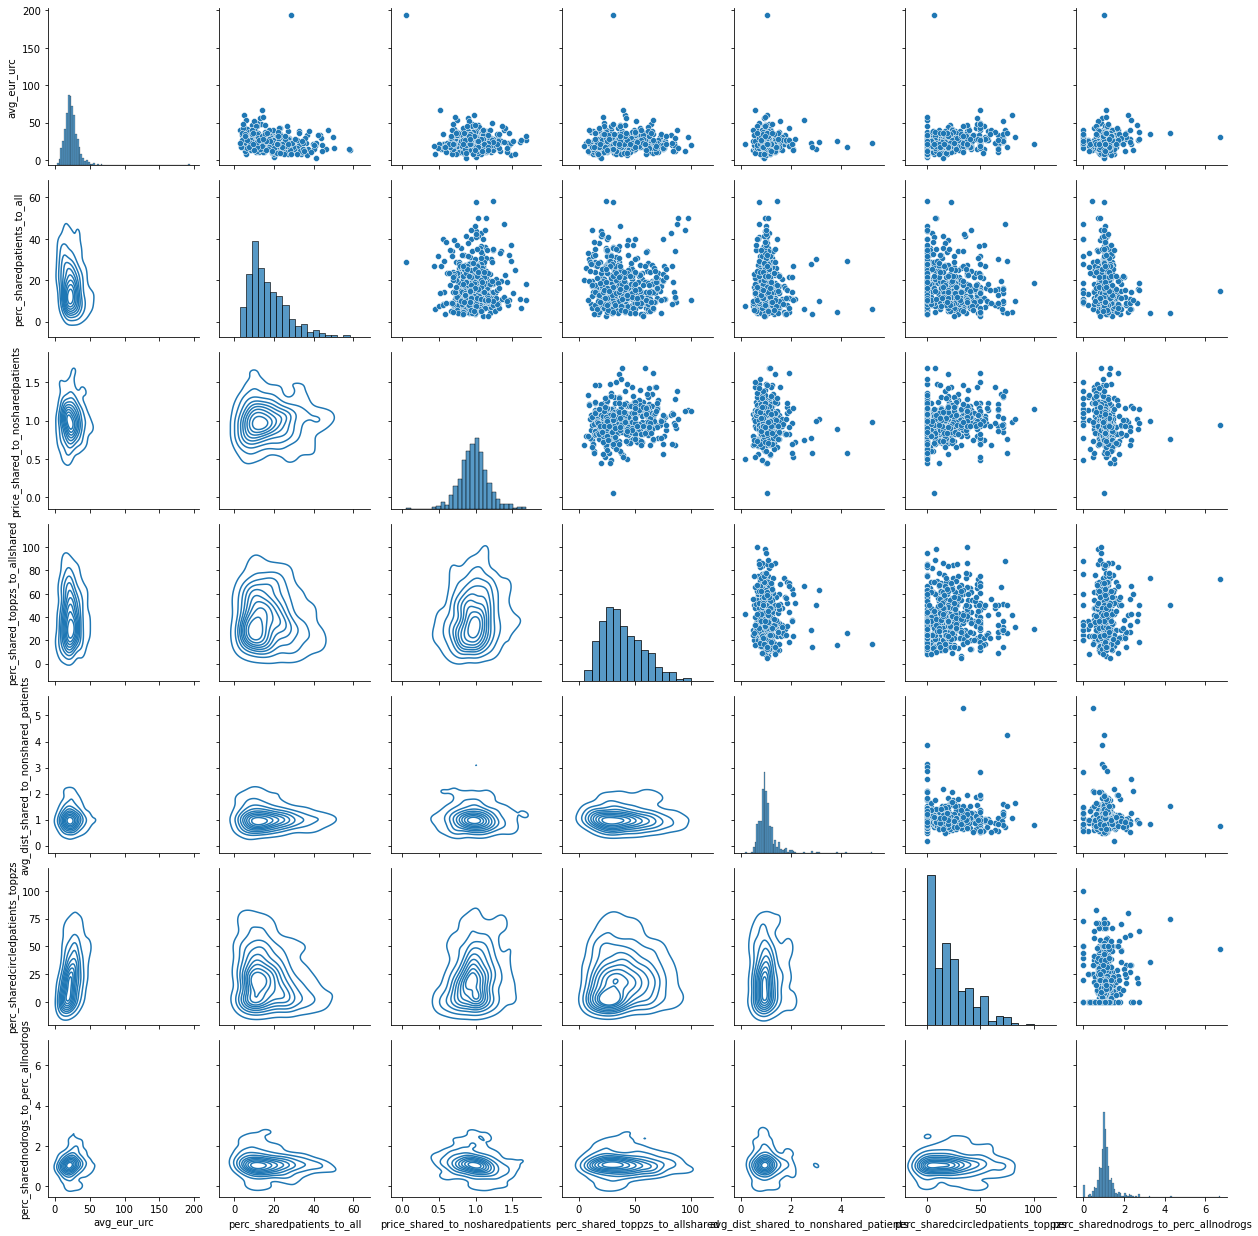

In [32]:
# let's look at distributions among features
g = sns.PairGrid(df_filtered)
_ = g.map_upper(sns.scatterplot)  # scatter plot
_ = g.map_lower(sns.kdeplot)  # kernel density estimate of probability distributiom
_ = g.map_diag(sns.histplot)  # histogram

In [33]:
# looking closely to distribution of avg_dist_shared_to_nonshared_patients feature
_ = sns.kdeplot(data=df_filtered["avg_dist_shared_to_nonshared_patients"])

In [34]:
# how many extreme otliers in the tail?
len(df_filtered[df_filtered["avg_dist_shared_to_nonshared_patients"] > 2.5])

8

In [35]:
# vs how many normal?
len(df_filtered[df_filtered["avg_dist_shared_to_nonshared_patients"] < 2.5])

473

In [36]:
# let's create columns expressing how outlying is an instance as measured by percentil
df_filtered_percentil = pd.DataFrame()
for col in df_filtered.columns:
    df_filtered_percentil['percentil_' + col] = df_filtered[col].apply(lambda row: stats.percentileofscore(df_filtered[col], row))

In [37]:
# inspecting the dataframe
df_filtered_percentil

percentil_avg_eur_urc  percentil_perc_sharedpatients_to_all  \
0                 69.64657                              80.45738   
1                 38.25364                              27.75468   
2                 42.20374                              35.96674   
3                 43.24324                              70.68607   
4                 75.25988                              60.29106   
..                     ...                                   ...   
497               71.10187                              49.48025   
498               40.54054                              86.07069   
499                7.06861                              66.73597   
500               92.30769                              20.99792   
501               91.89189                              57.79626   

     percentil_price_shared_to_nosharedpatients  \
0                                      13.51351   
1                                      98.33680   
2                                      28.89813   
3                                      44.07484   
4                                      16.21622   
..                                          ...   
497                                    38.66944   
498                                    20.99792   
499                                    75.05198   
500                                    22.66112   
501                                     8.73181   

     percentil_perc_shared_toppzs_to_allshared  \
0                                     21.20582   
1                                     10.18711   
2                                     12.47401   
3                                     41.68399   
4                                     12.68191   
..                                         ...   
497                                   30.76923   
498                                   82.95218   
499                                   97.92100   
500                                   88.98129   
501                                   61.74636   

     percentil_avg_dist_shared_to_nonshared_patients  \
0                                           64.86486   
1                                           82.12058   
2                                           14.96881   
3                                           54.05405   
4                                           68.19127   
..                                               ...   
497                                         91.06029   
498                                         61.74636   
499                                         80.66528   
500                                         83.36798   
501                                          4.78170   

     percentil_perc_sharedcircledpatients_toppzs  \
0                                       36.59044   
1                                       76.50728   
2                                       10.81081   
3                                       60.70686   
4                                       80.87318   
..                                           ...   
497                                     83.67983   
498                                     45.11435   
499                                     10.81081   
500                                     51.35135   
501                                     42.41164   

     percentil_perc_sharednodrogs_to_perc_allnodrogs  
0                                           72.97297  
1                                           31.60083  
2                                            6.02911  
3                                           55.92516  
4                                           13.51351  
..                                               ...  
497                                         78.58628  
498                                         55.71726  
499                                         56.75676  
500                                         53.22245  
501                                         58.62786  

[481 rows x 7 c

In [38]:
# filtering 3 sigma outliers in any of features = "apparent" outliers
apparent_outliers = df_filtered_percentil[(df_filtered_percentil>99.7).any(axis=1)]
apparent_outliers

percentil_avg_eur_urc  percentil_perc_sharedpatients_to_all  \
32                82.12058                              99.37630   
106                8.31601                             100.00000   
131               11.64241                              99.79210   
138               45.11435                              64.65696   
192               81.49688                              51.55925   
258               99.79210                              45.11435   
264               68.19127                              26.81913   
268               23.70062                              90.02079   
342              100.00000                              89.18919   
365               83.78378                              63.40956   
378               80.87318                              23.49272   
410               53.84615                               6.44491   
446               91.68399                               1.45530   
473               33.26403                              27.02703   

     percentil_price_shared_to_nosharedpatients  \
32                                     82.74428   
106                                    92.09979   
131                                    56.96466   
138                                    84.61538   
192                                    41.99584   
258                                     1.24740   
264                                    99.79210   
268                                     2.49480   
342                                     0.20790   
365                                   100.00000   
378                                    60.70686   
410                                    51.14345   
446                                    12.26611   
473                                    80.66528   

     percentil_perc_shared_toppzs_to_allshared  \
32                                    99.79210   
106                                   22.34927   
131                                   39.08524   
138                                   36.69439   
192                                   94.59459   
258                                   57.90021   
264                                   83.36798   
268                                   28.79418   
342                                   37.62994   
365                                   56.34096   
378                                   40.33264   
410                                    9.04366   
446                                   74.01247   
473                                  100.00000   

     percentil_avg_dist_shared_to_nonshared_patients  \
32                                          50.72765   
106                                         90.02079   
131                                         12.47401   
138                                         17.46362   
192                                         14.34511   
258                                          2.07900   
264                                         72.76507   
268                                         99.79210   
342                                         60.70686   
365                                         78.17048   
378                                         93.97089   
410                                        100.00000   
446                                         90.85239   
473                                          8.10811   

     percentil_perc_sharedcircledpatients_toppzs  \
32                                      31.80873   
106                                     10.81081   
131                                     59.25156   
138                                    100.00000   
192                                     88.35759   
258                                     91.26819   
264                                     30.56133   
268                                     99.27235   
342                                     27.23493   
365                                     10.81081   
378                                     99.79210   
41

In [39]:
# drill down to one outlier
apparent_outliers.loc[32]

percentil_avg_eur_urc                             82.12058
percentil_perc_sharedpatients_to_all              99.37630
percentil_price_shared_to_nosharedpatients        82.74428
percentil_perc_shared_toppzs_to_allshared         99.79210
percentil_avg_dist_shared_to_nonshared_patients   50.72765
percentil_perc_sharedcircledpatients_toppzs       31.80873
percentil_perc_sharednodrogs_to_perc_allnodrogs   11.43451
Name: 32, dtype: float64

In [40]:
# after a discussion with the subject matter expert we decided to filter out these "apparent" outliers, these would be investigated separately

# we can filter these "apparent" outliers from further analysis
filter_out = df_filtered.index.isin(apparent_outliers.index)
df_filtered_w3s = df_filtered[~filter_out]

- this is similar to what rule-based systems do, here the "thresholds" are computed from the data (3-sigma levels), so have a statistical meaning

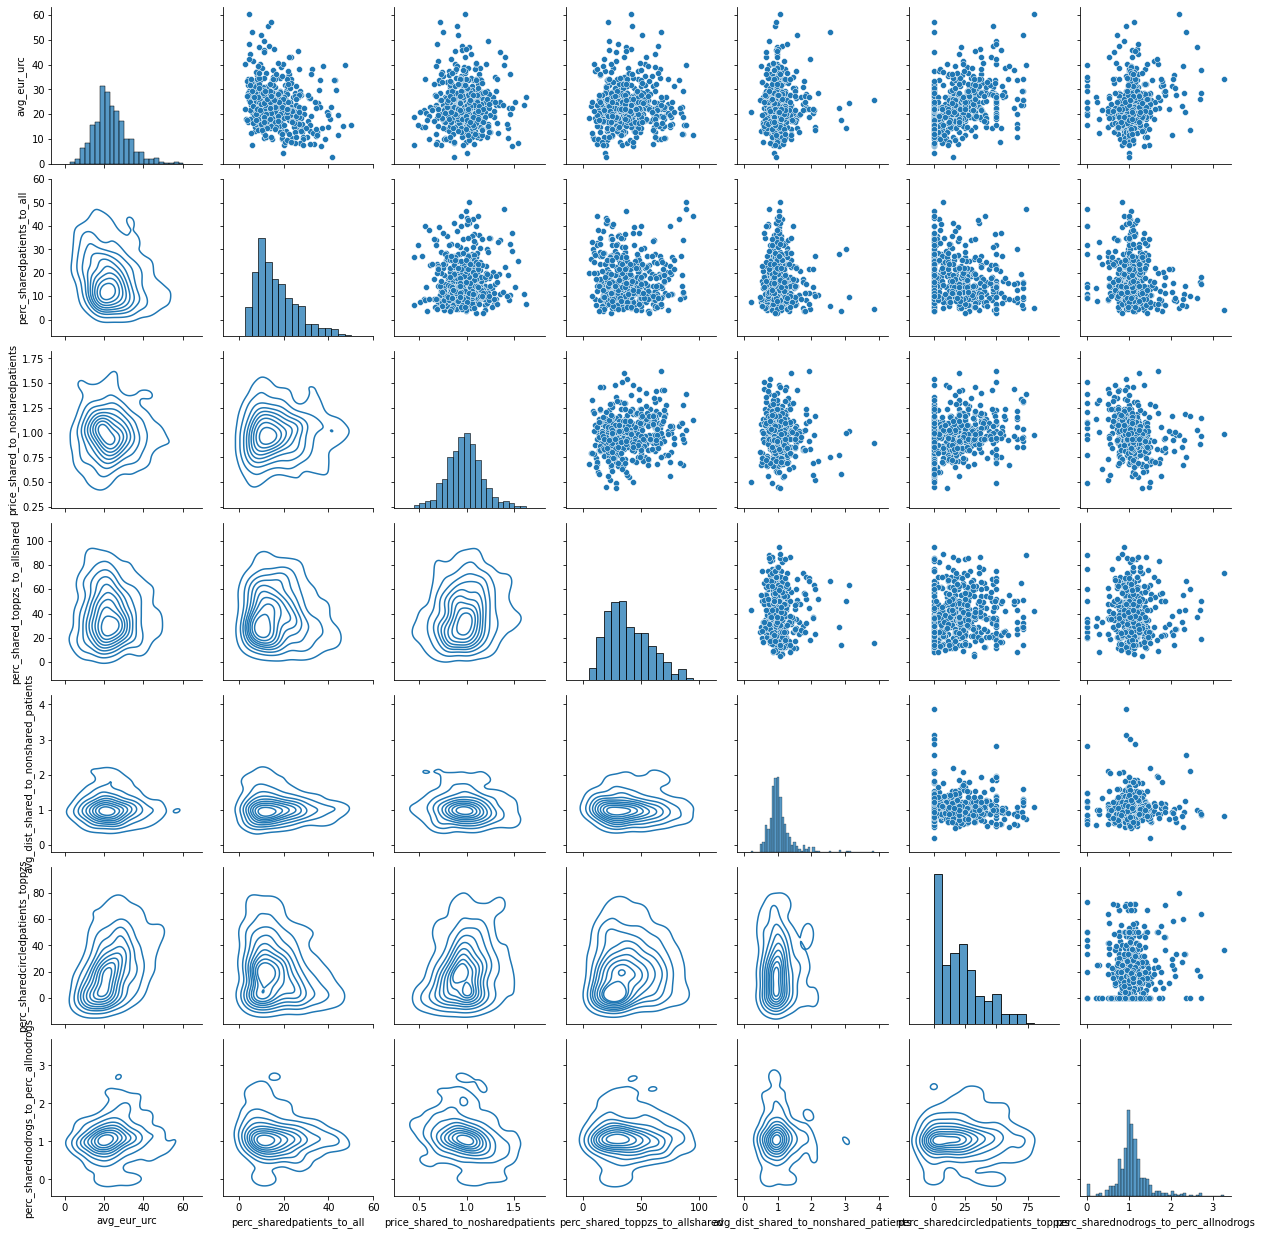

In [41]:
# checking distributions now
g = sns.PairGrid(df_filtered_w3s)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)

- let's use clustering for further investigation of "not-so-apparent" outliers

---

<h3>DBSCAN</h3>

<img src="images/kmeans_vs_dbscan.png" width=600>
image source and details: <a href=https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html>https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html</a>

- DBSCAN clustering algorithm works well even when the clusters have some special symmetries and classical k-means clustering give poor results
- DBSCAN is based on density, rather than distance from cluster center only as in the case of k-means
- see https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html

In [42]:
# the ML pipeline
ml_pl = Pipeline([
    ('interactions', PolynomialFeatures(degree=2, interaction_only=True)),  # we can incorporate interactions easily
    ('scale', StandardScaler()),  # scaling - standardizing - mean = 0, variance = 1
    ('dbscan', DBSCAN(eps=5, min_samples=3))  # dbscan model
    ])

- details on StandardScaler: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [43]:
# run pipeline, train the model
ml_pl.fit(df_filtered_w3s)

Pipeline(steps=[('interactions', PolynomialFeatures(interaction_only=True)),
                ('scale', StandardScaler()),
                ('dbscan', DBSCAN(eps=5, min_samples=3))])

In [44]:
# accessing the model labels
# 0 = normal
# -1 = outlier

labels = ml_pl['dbscan'].labels_
print(labels)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0
  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0

- now we want to visualize the outliers in the feature space, for this purpose we need use some dimensionality reduction technique

<h3> Principal Components Analysis (PCA) </h3>

- dimensionality reduction technique
- it is a projection based method that transforms the data by projecting it onto a set of orthogonal axes chosen in a way that these point in a direction of maximal variance in the original data
- it creates new features such that there is a linear relationship between the new and original features such that the variance is maximised

<img src="images/pca.gif" width=600>
image source and details: <a href=https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues>https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues</a>

In [45]:
# PCA pipeline
pca_pl = Pipeline([
    ('interactions', PolynomialFeatures(degree=2, interaction_only=True)),
    ('scale', StandardScaler()),  # scaling - standardizing - mean = 0, variance = 1
    ('pca', PCA(n_components=6))  # PCA, 6 components as an example
    ])

In [46]:
# perform PCA to 6 components - just example of PCA pipeline usage
pca_pl.fit(df_filtered_w3s)

Pipeline(steps=[('interactions', PolynomialFeatures(interaction_only=True)),
                ('scale', StandardScaler()), ('pca', PCA(n_components=6))])

In [47]:
# fraction of variance explained by individial components
var_explained = pca_pl["pca"].explained_variance_ratio_
print(var_explained)

[0.27155212 0.17634217 0.14701734 0.12024313 0.10469684 0.07566405]


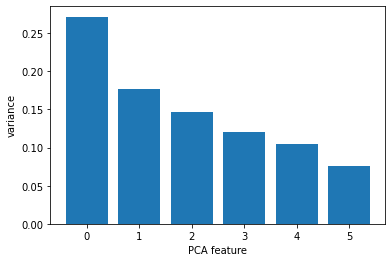

In [48]:
# plot the explained variances of individual PCA components
features = range(pca_pl["pca"].n_components_)
plt.bar(features, var_explained)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [50]:
# cumulative sum of var_explained
cum_sum_var = np.cumsum(var_explained*100)

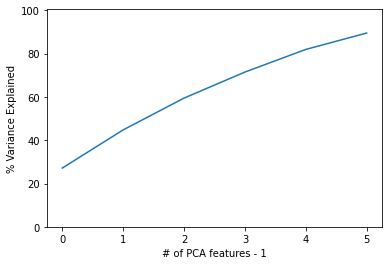

In [51]:
# plot the cumulative sum of variance explained as fucntion of number of PCA features
plt.ylabel('% Variance Explained')
plt.xlabel('# of PCA features - 1')
plt.ylim(0,100.5)
_ = plt.plot(cum_sum_var)

- note that 0 here does not mean that we have 0 features, but that we have 1

In [52]:
# PCA pipeline - finally, down to 2 components for visualization
pca_pl = Pipeline([
    ('interactions', PolynomialFeatures(degree=2, interaction_only=True)),
    ('scale', StandardScaler()),  # scaling - standardizing - mean = 0, variance = 1
    ('pca', PCA(n_components=2))  # PCA
    ])

In [53]:
# fit_transform return transformed components
pca_data = pca_pl.fit_transform(df_filtered_w3s)

In [54]:
# inspect the data
df_pca = pd.DataFrame(data=pca_data, columns=['pc1', 'pc2'])
df_pca.head()

pc1      pc2
0 -1.47029  0.32750
1  0.79086 -1.28241
2 -3.85346 -1.73655
3 -0.50094  0.43511
4  0.17176 -0.64768

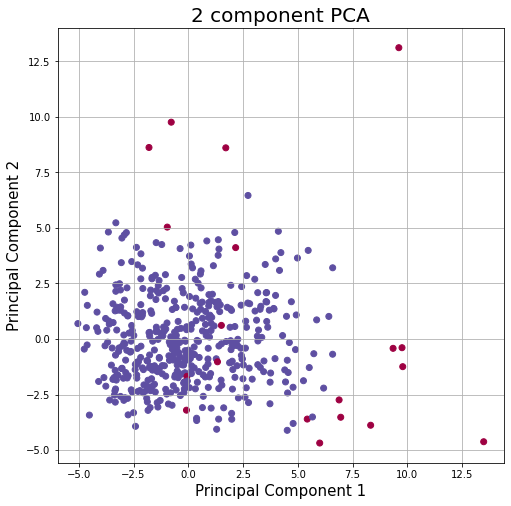

In [55]:
# plot 2D space of 2 variance-dominant pca components

# manage figure
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

# add axes labels
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

# add plot title
ax.set_title('2 component PCA', fontsize = 20)

# color map scheme
cmap = plt.cm.Spectral

# scatter plot with two groups being differentiated by color
ax.scatter(df_pca['pc1'], df_pca['pc2'], c=labels, cmap=cmap)

# add grid
ax.grid()

- we used PCA to create two most variance-dominant dimmensions and finally plot outliers in this space - those red in the figure above

<h3> Parameter search </h3>

**Elbow method**

- method for estimating *eps* (radius) parameter of DBSCAN

In [56]:
# scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered_w3s)

# interactions
interactions = PolynomialFeatures(degree=2, interaction_only=True)
X_scaled_int = interactions.fit_transform(X_scaled)

# compute distances for each point in each point's neighborhood
nn = NearestNeighbors(n_neighbors=100).fit(X_scaled_int)  # check with different values of n_neighbors
distances, idx = nn.kneighbors(X_scaled_int)

# sort from smalles
distances = np.sort(distances, axis=0)

# take smallest distance for each point (note that we are not taking [:,0] because the point itself is included in the original array)
distances = distances[:,1]

In [57]:
# plot the Elbow curve
plt.figure(figsize=(7,5))
plt.plot(distances)
plt.xlabel("#")
plt.ylabel("distance")
plt.show()

- elbow is at distance 5-ish -> we expect *eps*=5 to perform well for our DBSCAN model
- actually, we already used *eps*=5
- see <a href=https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues>https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues</a> for details on DBSCAN parameters

- robust method for finding parameters - grid search in parameter space, looking e.g. at Silhoutte score ("goodness" of clusters) for each distinct model
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [58]:
# Silhoutte coefficent score is easily accesible
metrics.silhouette_score(X_scaled, labels)

0.4191865119014904

<h3> Interactive plot </h3>

In [59]:
# plotly interactive plot - try to run this cell
# this is handy when we want identify outliers in the plot
_ = plotly.offline.plot({
    "data": [
        Scatter(x=df_pca['pc1'].tolist(), 
                y=df_pca['pc2'].tolist(), 
                mode='markers', 
                marker=dict(
                    size=15,
                    color=labels,  # set color according to cluster
                    colorscale='Viridis',  # one of plotly colorscales
                    ),
                text=df_pca.index.tolist())  # here we could have actual identifiers of data points
    ],
    "layout": Layout(
        title="2 component PCA",
        xaxis_title="principal component 1",
        yaxis_title="principal component 2",
    )
})